In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt

Prepare the dataset


In [2]:
splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'], data_dir='./data')

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ./data/horses_or_humans/3.0.0.incomplete49HRUA/horses_or_humans-train.tfrecord


  0%|          | 0/1027 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ./data/horses_or_humans/3.0.0.incomplete49HRUA/horses_or_humans-test.tfrecord


  0%|          | 0/256 [00:00<?, ? examples/s]

Dataset horses_or_humans downloaded and prepared to ./data/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

Pre-process an image

In [4]:
# Create a autograph pre-processing function to resize and normalize an image
### START CODE HERE ###
@tf.function
def map_fn(img, label):
    image_height = 224
    image_width = 224
    # resize the image
    img = tf.image.resize(img, (224, 224)) 
    # normalize the image
    img /= 255.0
    return img, label

Apply pre-processing to the datasets

In [5]:
# Prepare train dataset by using preprocessing with map_fn, shuffling and batching
def prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, batch_size):
    train_ds = train_examples.map(map_fn).shuffle(buffer_size = num_examples).batch(batch_size) 
    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)
    
    return train_ds, valid_ds, test_ds

In [6]:
train_ds, valid_ds, test_ds = prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, BATCH_SIZE)

Define the model


In [7]:
MODULE_HANDLE = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,568,898
Trainable params: 4,098
Non-trainable params: 23,564,800
_________________________________________________________________


Define optimizer

In [8]:
def set_adam_optimizer():
    # Define the adam optimizer
    optimizer = tf.keras.optimizers.Adam() 
    return optimizer

Define the loss function

In [9]:
def set_sparse_cat_crossentropy_loss():
    # Define object oriented metric of Sparse categorical crossentropy for train and val loss
    train_loss = tf.keras.losses.SparseCategoricalCrossentropy()  
    val_loss = tf.keras.losses.SparseCategoricalCrossentropy() 
    return train_loss, val_loss

Define the acccuracy function 

In [10]:
def set_sparse_cat_crossentropy_accuracy():
    # Define object oriented metric of Sparse categorical accuracy for train and val accuracy
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy() 
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy() 
    return train_accuracy, val_accuracy

Call the three functions that you defined to set the optimizer, loss and accuracy



In [11]:
optimizer = set_adam_optimizer()
train_loss, val_loss = set_sparse_cat_crossentropy_loss()
train_accuracy, val_accuracy = set_sparse_cat_crossentropy_accuracy()

Define the training loop

In [12]:
# this code uses the GPU if available, otherwise uses a CPU
device = '/gpu:0' if tf.test.is_gpu_available() else '/cpu:0'
EPOCHS = 1

# Custom training step
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    '''
    Trains on a batch of images for one step.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        x (Tensor) -- training images
        y (Tensor) -- training labels
        train_loss (keras Loss) -- loss object for training
        train_accuracy (keras Metric) -- accuracy metric for training
    '''
    with tf.GradientTape() as tape:
        # Run the model on input x to get predictions
        predictions = model(x) 
        # Compute the training loss using `train_loss`, passing in the true y and the predicted y
        loss = train_loss(y, predictions)

    # Using the tape and loss, compute the gradients on model variables using tape.gradient
    grads = tape.gradient(loss, model.trainable_variables) 
    
    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) 

    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y, predictions)
    return loss

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Define the 'train' function

In [13]:
# Decorate this function with tf.function to enable autograph on the training loop
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    '''
    Performs the entire training loop. Prints the loss and accuracy per step and epoch.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        epochs (int) -- number of epochs
        train_ds (tf Dataset) -- the train set containing image-label pairs
        train_loss (keras Loss) -- loss function for training
        train_accuracy (keras Metric) -- accuracy metric for training
        valid_ds (Tensor) -- the val set containing image-label pairs
        val_loss (keras Loss) -- loss object for validation
        val_accuracy (keras Metric) -- accuracy metric for validation
    '''
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            # training step number increments at each iteration
            step += 1
            with tf.device(device_name=device):
                # Run one training step by passing appropriate model parameters
                # required by the function and finally get the loss to report the results
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
            # Use tf.print to report your results.
            # Print the training step number, loss and accuracy
            tf.print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)
        
        # Print the validation loss and accuracy
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())

In [14]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy)

Step 1 : train loss 1.2593534 ; train accuracy 0.5
Step 2 : train loss 0.668914855 ; train accuracy 0.59375
Step 3 : train loss 0.61919868 ; train accuracy 0.625
Step 4 : train loss 0.417958498 ; train accuracy 0.6640625
Step 5 : train loss 0.219335854 ; train accuracy 0.725
Step 6 : train loss 0.160941094 ; train accuracy 0.765625
Step 7 : train loss 0.171533644 ; train accuracy 0.790178597
Step 8 : train loss 0.0745949149 ; train accuracy 0.81640625
Step 9 : train loss 0.0808648 ; train accuracy 0.836805582
Step 10 : train loss 0.0638207719 ; train accuracy 0.853125
Step 11 : train loss 0.053776633 ; train accuracy 0.866477251
Step 12 : train loss 0.0258801207 ; train accuracy 0.877604187
Step 13 : train loss 0.0200661682 ; train accuracy 0.887019217
Step 14 : train loss 0.020170562 ; train accuracy 0.895089269
Step 15 : train loss 0.0131742228 ; train accuracy 0.902083337
Step 16 : train loss 0.00889476 ; train accuracy 0.908203125
Step 17 : train loss 0.00832502916 ; train accuracy

Evaluation


In [15]:
test_imgs = []
test_labels = []

predictions = []
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model(images)
        preds = preds.numpy()
        predictions.extend(preds)

        test_imgs.extend(images.numpy())
        test_labels.extend(labels.numpy())

In [16]:
# Utilities for plotting

class_names = ['horse', 'human']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    # green-colored annotations will mark correct predictions. red otherwise.
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # print the true label first
    print(true_label)
  
    # show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

0


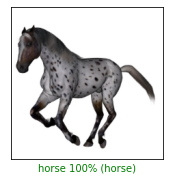

In [17]:
# Visualize the outputs 

# you can modify the index value here from 0 to 255 to test different images
index = 8 
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()